# How are microbial communities affected by increasing numbers of chemical stressors?

*Tom Smith Jan 2023*

Some basic analyses on a test dataset to try to look at how community composition changes with increasing numbers of stressors, and potentially answer some of the questions raised by Tom Clegg's modelling work.

Some questions we might try to answer:

 * Do communities tend to lose specialist or generalist species when under stress?
 * Do communities tend to get more competitive or co-operative with stress?
 * Do we tend to lose more rare or abuntant taxa with chemical stress?
 * Does stress make communities more phylogenetically clustered or dispersed?
 * What can we infer about functional diversity?
 
Microbial communities were grown for 3 days in media supplemented with combinations of 8 chemical stressors. Optical density was measured every hour for the duration. At the final timepoint, communities were frozen at -80C. We extracted DNA and sequenced a subset of those communities to look at changes in composition. These sequenced communities were controls, each single chemical treatment, four 2-chemical treatments, 2 4-chemical treatments, and the 8-chemical treatment, such that the smaller chemical mixtures are subsets of the larger.

### MAJOR DISCLAIMER - THE SEQUENCING DATA ARE NOT GOOD - TAKE ANY RESULTS WITH LARGE GRAIN OF SALT

We sequenced the 16S V3 and V4 regions using illumina paired-end sequencing on the MiSeq, like this:

![](images/paired-end-diagram.png "Paired end sequencing")

Unfortunately, the read quality was very poor:

![](images/sequence-quality.png "Read quality")

Remember that Q scores are a logarithmic quality scale, 

$$Q = -10log_{10}(e),$$ 

where e is the error rate. This works out as Q10 is a 10% error rate, Q20 is a 1% error rate, Q30 is a 0.1% error rate.

Ideally, we want high quality scores (>30) across the whole length of the sequences, then we can take the paired reads and join them to get sequences covering the whole v3-v4 region. However, here most of the forward read data is completely unusable, while the reverse read data is only decent for the first 150 or so bases in most reads. We therefore can't join the reads and so don't have full v3-v4 region sequences.

But, to not completely waste this sequencing run, I'll try to use it as "test" data here for some exploratory analyses. I'll take the vaguely OK quality part of the reverse reads, and use those sequences only. This will mean we only have short length 16S sequences to work with, so rather than "species" we'll have to consider the OTUs returned as something more like genera or even families, i.e. each "OTU" here will represent an aggregate of similar things which would have been separated out were we to have longer high-quality sequences.

## Quick QIIME2 workflow

Paired-end reads were processed in QIIME 2. I applied the Deblur workflow using the `qiime deblur denoise-16S` method. This method requires one parameter that is used in quality filtering, `--p-trim-length n` which truncates the sequences at position n. I *very leniently* trimmed these reads at 220bp.

I did the downstream analysis of these trimmed reads using the python QIIME plugin to produce:

 * Taxonomy assignment: `run-1-taxonomy.qza`
 * Phylogeny with MAFFT fasttree: `run-1-rooted_tree.qza`
 * Rarefaction (subsample each community to a specific read depth) `rarefied_table.qza`, `rarefied_sequences.qza`


Great, now we can analyze this data - we'll do it in R.

## Step 1: Reading qiime artifacts into R

In [157]:
library(qiime2R)
library(phyloseq)
library(tidyverse)
library(gtools)
library(data.table)
library(stringr)

OTUs <- read_qza("../data/miseq-inhouse/rarefied_table.qza")

names(OTUs)

[1] "uuid"       "type"       "format"     "contents"   "version"   
[6] "data"       "provenance"

These qiime artifacts are a bit weird, need to access the data parts of the OTU table.

In [113]:
OTUs$data[1:5,1:5]

,Sample41,Sample64,Sample14,Sample58,Sample43
97562efe117405f4db814d84c4a1b99d,33,24,24,37,40
692fc60710b744c4d9b68f247ed47cf2,36,31,26,69,38
4ae50a40814d6171f3a7c1c128750999,27,22,19,41,19
1aac58cbd99933ef97e13f5e72c3f92f,34,49,12,0,14
03d62691f2499275393bd38435436557,25,17,17,29,37


In [186]:
SVs <- OTUs$data # SVs = "sequence variants"


# load in metadata to link samples with what the chemical treatments are
metadata <- read.csv("../data/miseq-inhouse/metadata-extended.csv")

head(metadata)

,SampleID,sample.well,final.conc,community.name,chem.code,Amoxicillin,Chlorothalonil,Diflufenican,Glyphosate,Imidacloprid,Metaldehyde,Oxytetracycline,Tebuconazole,complexity,TruePlateWell
,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,Sample1,A01,4.0,R_ID_7.16_1_R10(1)_TSS,Frozen Starting Community,NA,NA,NA,NA,NA,NA,NA,NA,0,NANA
2,Sample2,A02,4.0,R_ID_7.16_1_R10(1)_TSS,A,1,0,0,0,0,0,0,0,1,1B2
3,Sample3,A03,0.1,R_ID_7.16_1_R10(1)_TSS,O,0,0,0,0,0,0,1,0,1,1B3
4,Sample4,A04,4.0,R_ID_7.16_1_R10(1)_TSS,CM,0,1,0,0,0,1,0,0,2,1B5
5,Sample5,A05,0.0,R_ID_7.16_1_R10(1)_TSS,IO,0,0,0,0,1,0,1,0,2,1C7
6,Sample6,A06,4.0,R_ID_7.16_1_R10(1)_TSS,IT,0,0,0,0,1,0,0,1,2,1D7


## Taxonomy

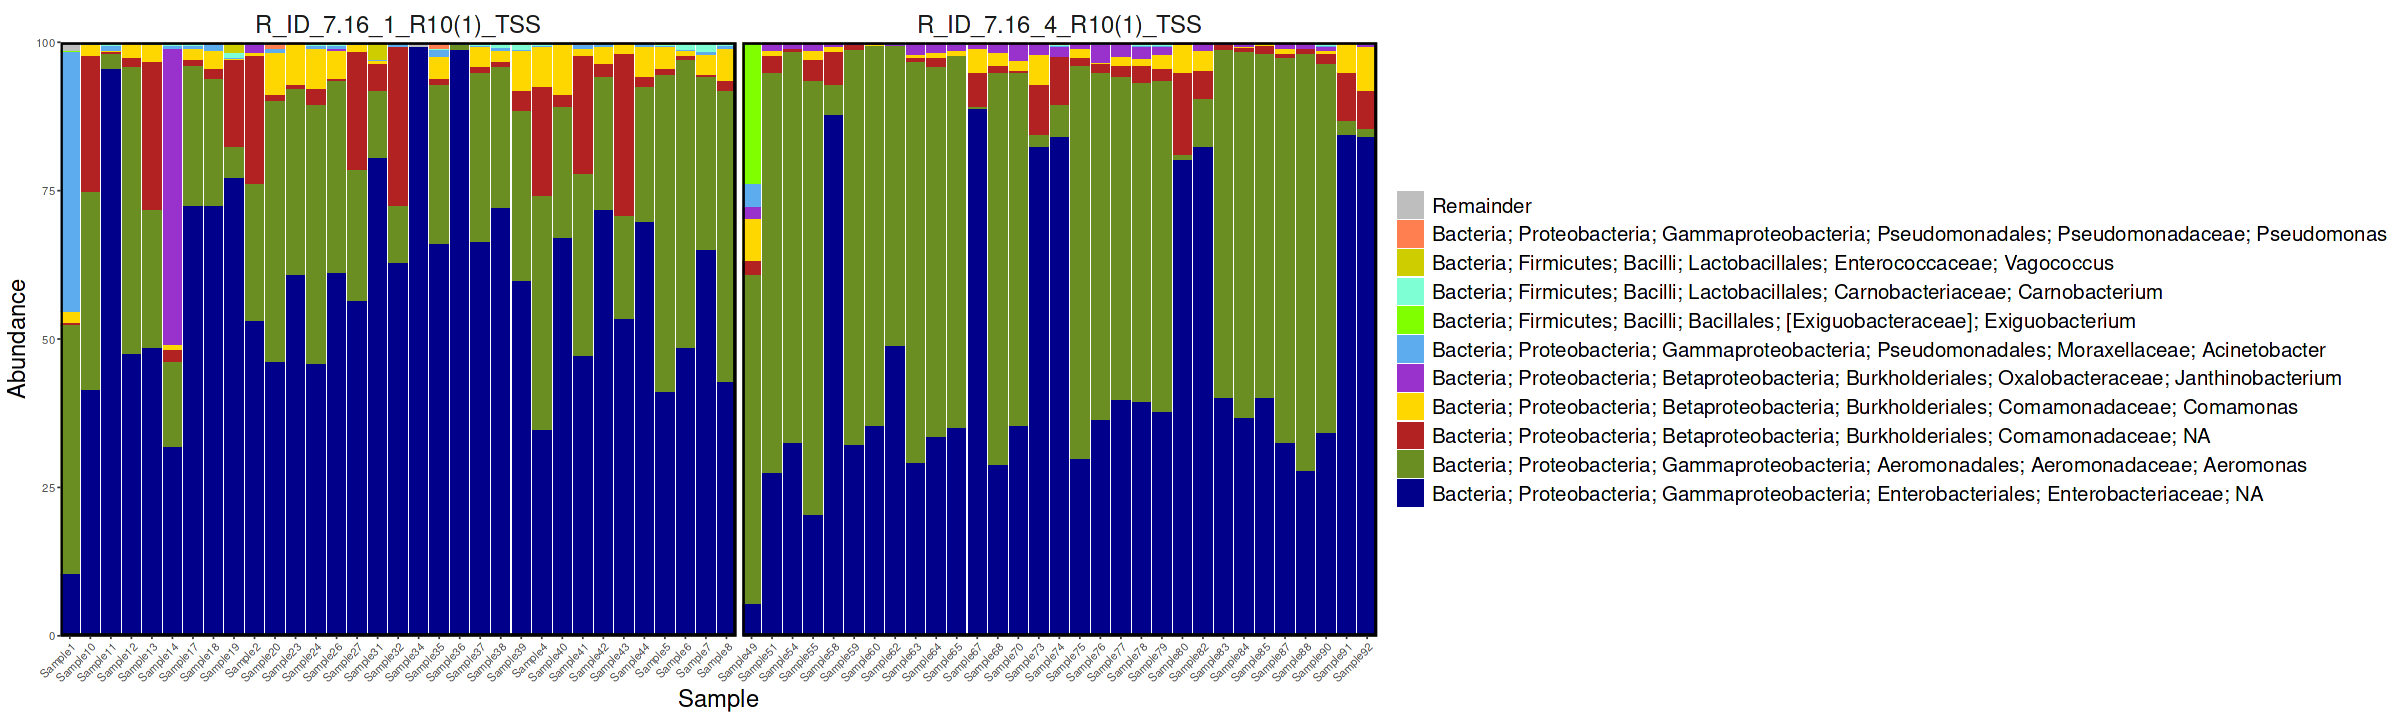

In [187]:
# read the file with taxonomy
taxonomy <- read_qza("../data/miseq-inhouse/run-1-taxonomy.qza")$data %>% parse_taxonomy()

taxasums <- summarize_taxa(SVs, taxonomy)$Genus

options(repr.plot.width = 20, repr.plot.height = 6)
taxa_barplot(taxasums, metadata, "community.name") +
  theme(strip.text = element_text(size = 14),
       axis.title = element_text(size = 14),
       legend.text = element_text(size = 12))


## Phylogeny

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘tidytree’

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


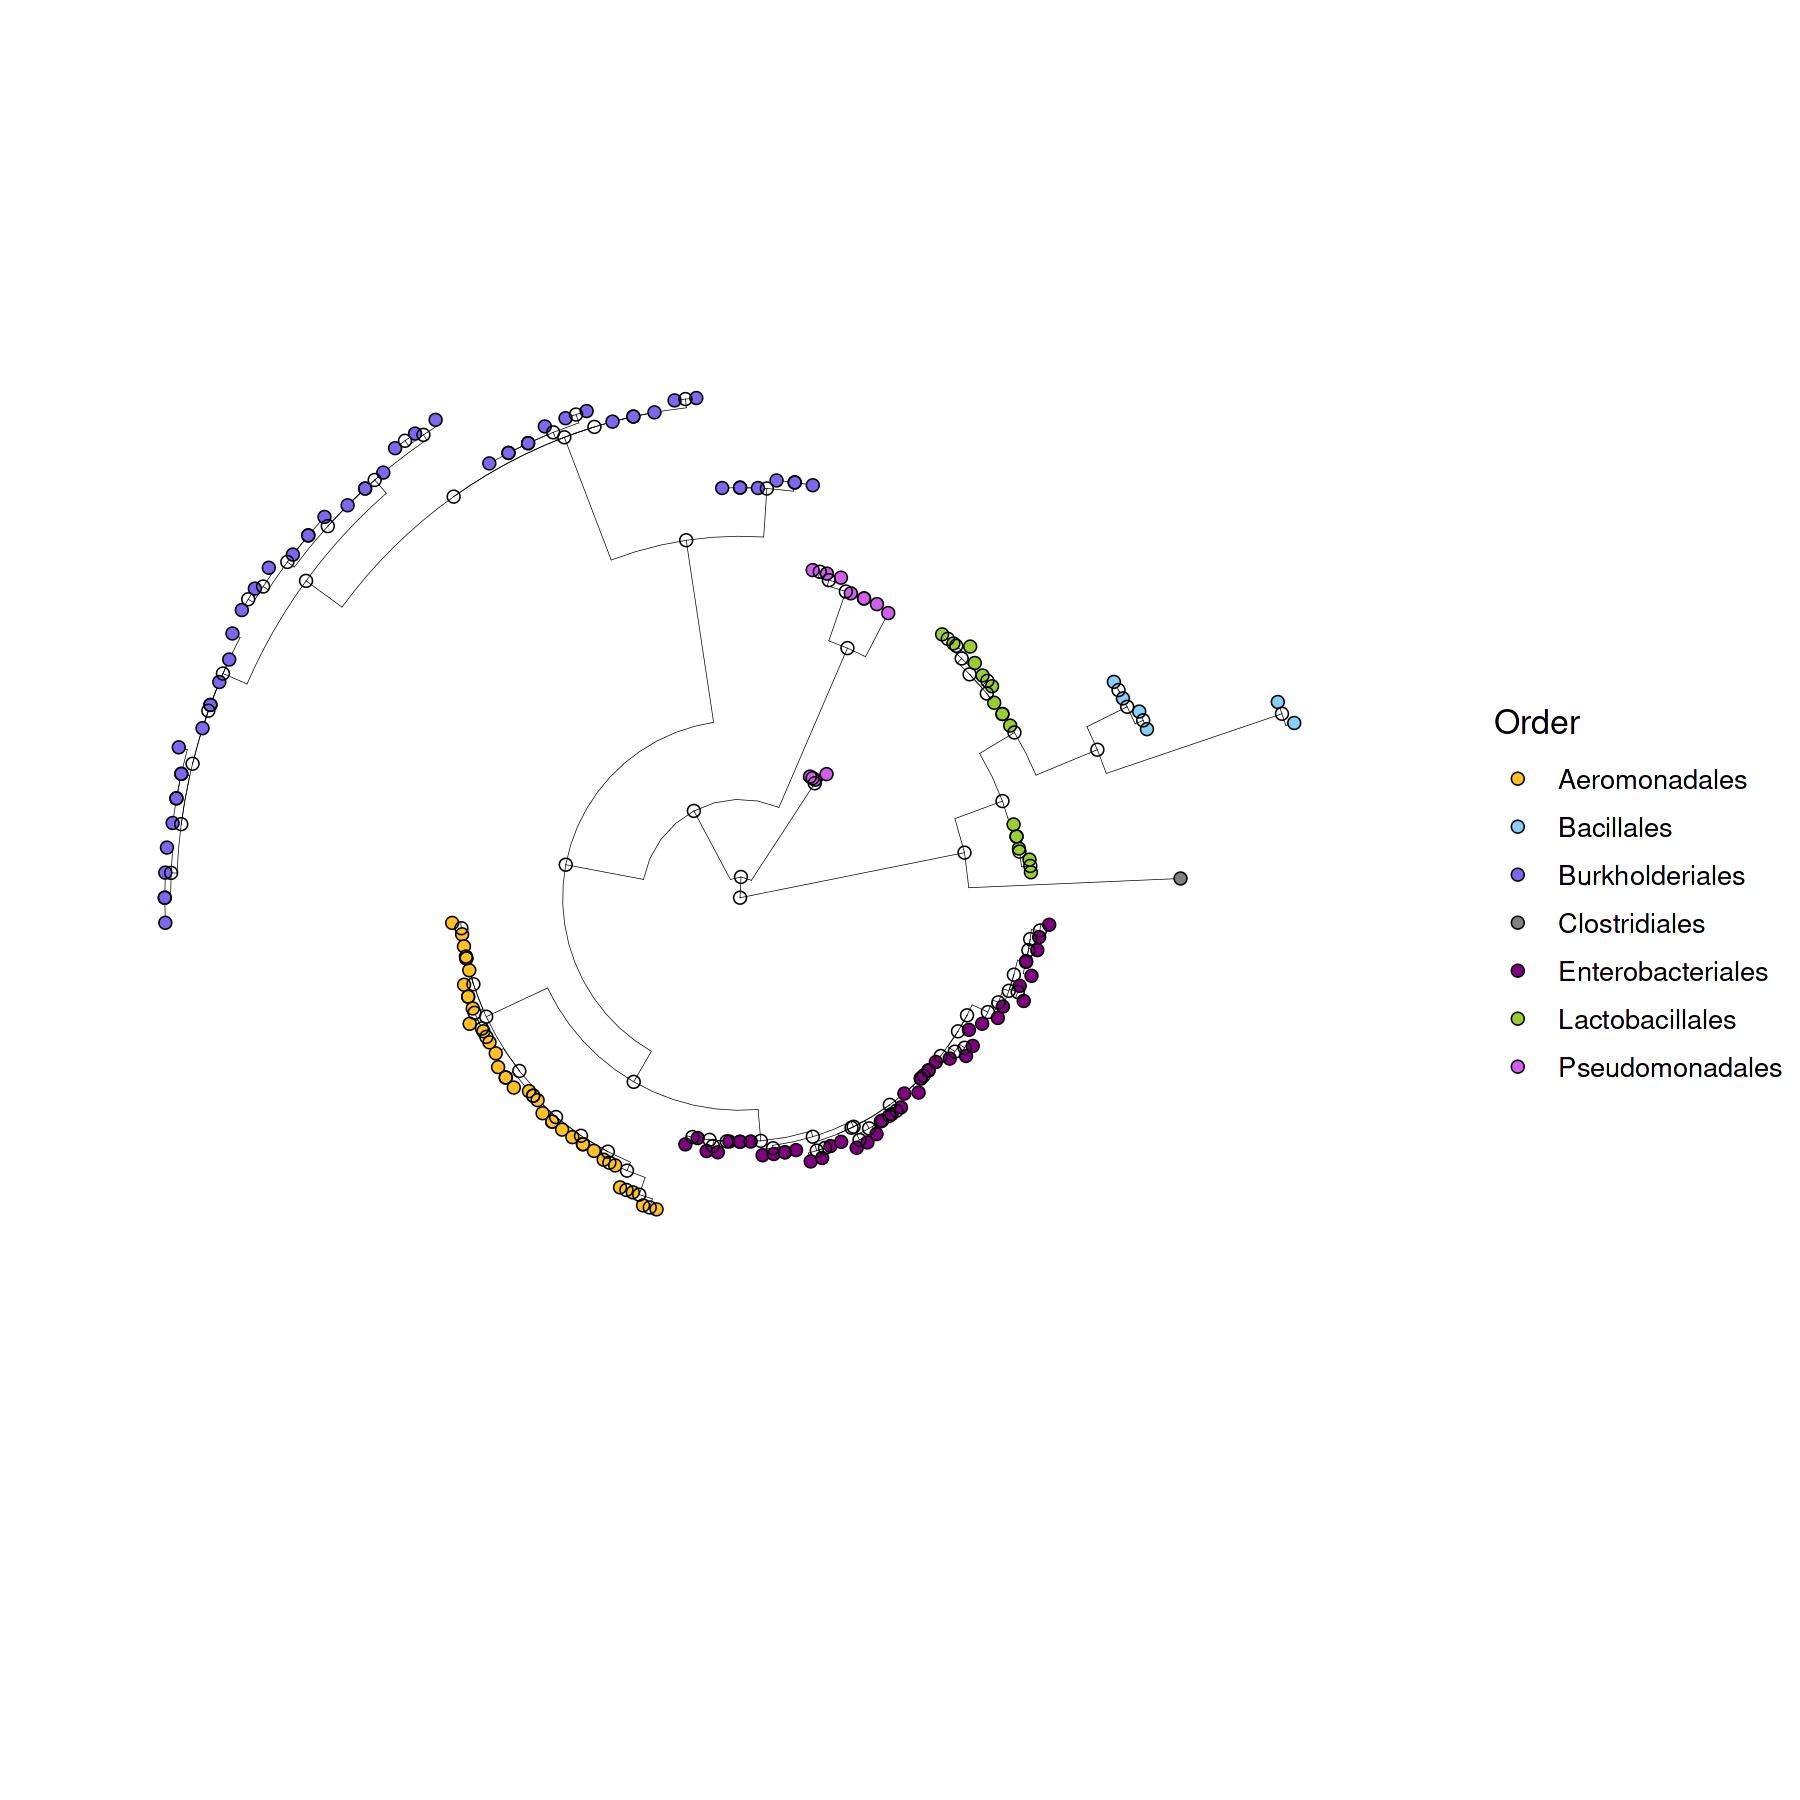

In [188]:
# Read the phylogeny artifact
tree <- read_qza("../data/miseq-inhouse/run-1-rooted_tree.qza")$data

library(ggtree) # mess around with some pretty plotting of the phylogeny

# need to get some of this into ggplot readable dataframes
taxa_df <- data.frame(ID = rownames(taxonomy), Phylum = taxonomy$Phylum, Class = taxonomy$Class, Order = taxonomy$Order)

# do some fancy plotting with ggtree
p2 <- ggtree(tree, layout="fan", size=0.15, open.angle=5) 

p2 <- p2 %<+% taxa_df + geom_point(
  mapping=aes(fill=Order),
  position="identity", shape = 21, size = 3) +
  scale_fill_manual(values=c("#FFC125","#87CEFA","#7B68EE","#808080",
                             "#800080", "#9ACD32","#D15FEE","#FFC0CB",
                             "#EE6A50","#8DEEEE", "#006400","#800000",
                             "#B0171F","#191970"),
                    guide=guide_legend(keywidth = 2, 
                                       keyheight = 2, order=1,
                                       override.aes=list(shape=21)),
                    na.translate=FALSE) +
  theme(legend.text = element_text(size = 16),
       legend.title = element_text(size = 20))

options(repr.plot.width = 15, repr.plot.height = 15)
p2

## Analysis Part 1 - Diversity metrics

How does community diversity vary with increasing number of chemical stressors?

Joining, by = "SampleID"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


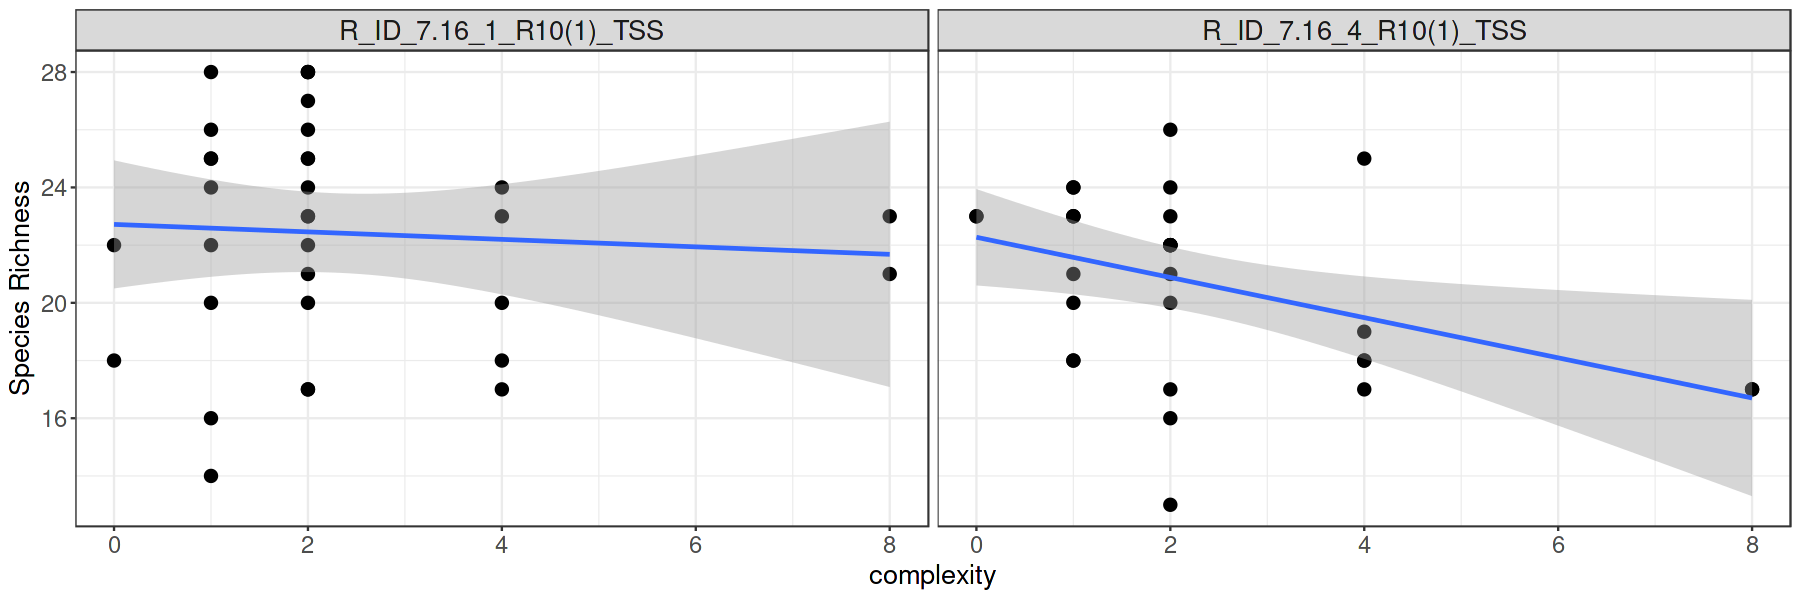

`geom_smooth()` using formula = 'y ~ x'


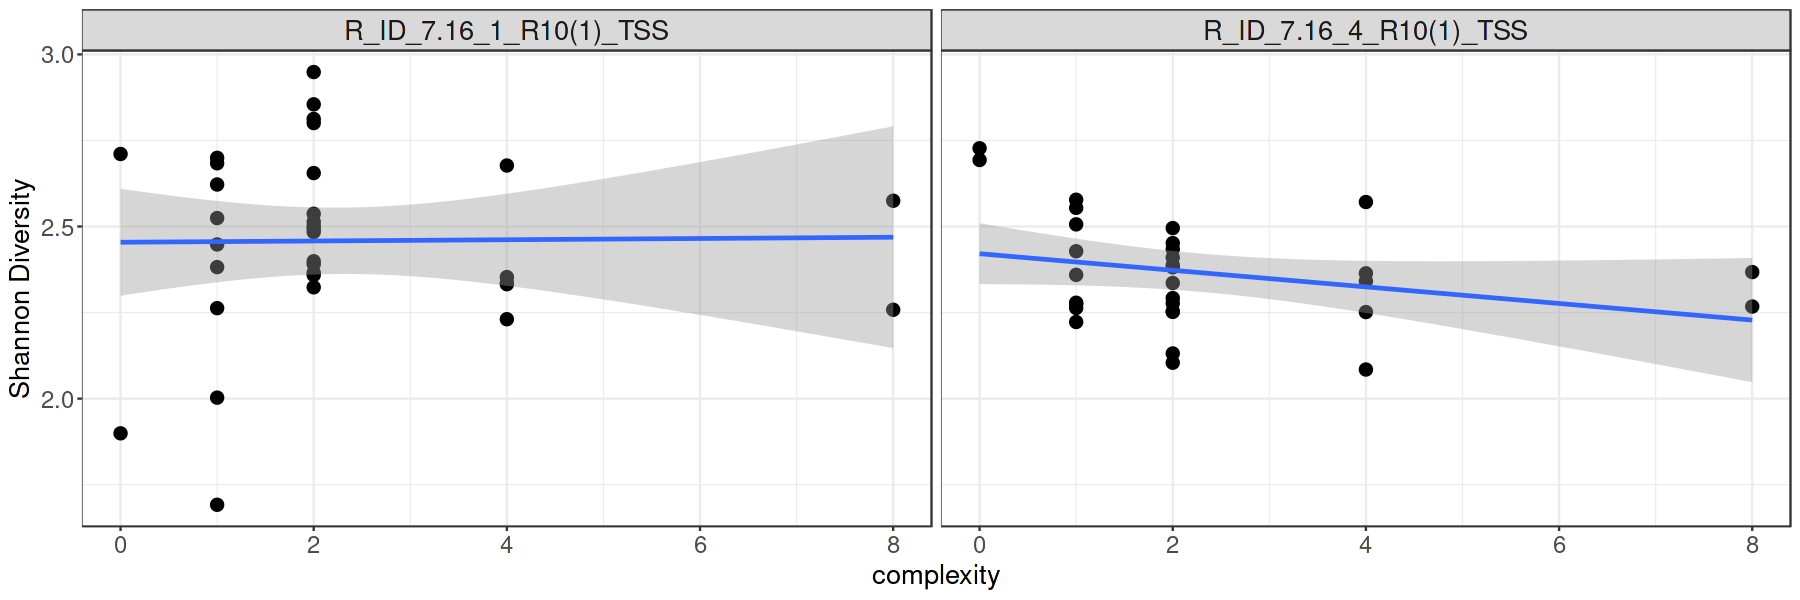

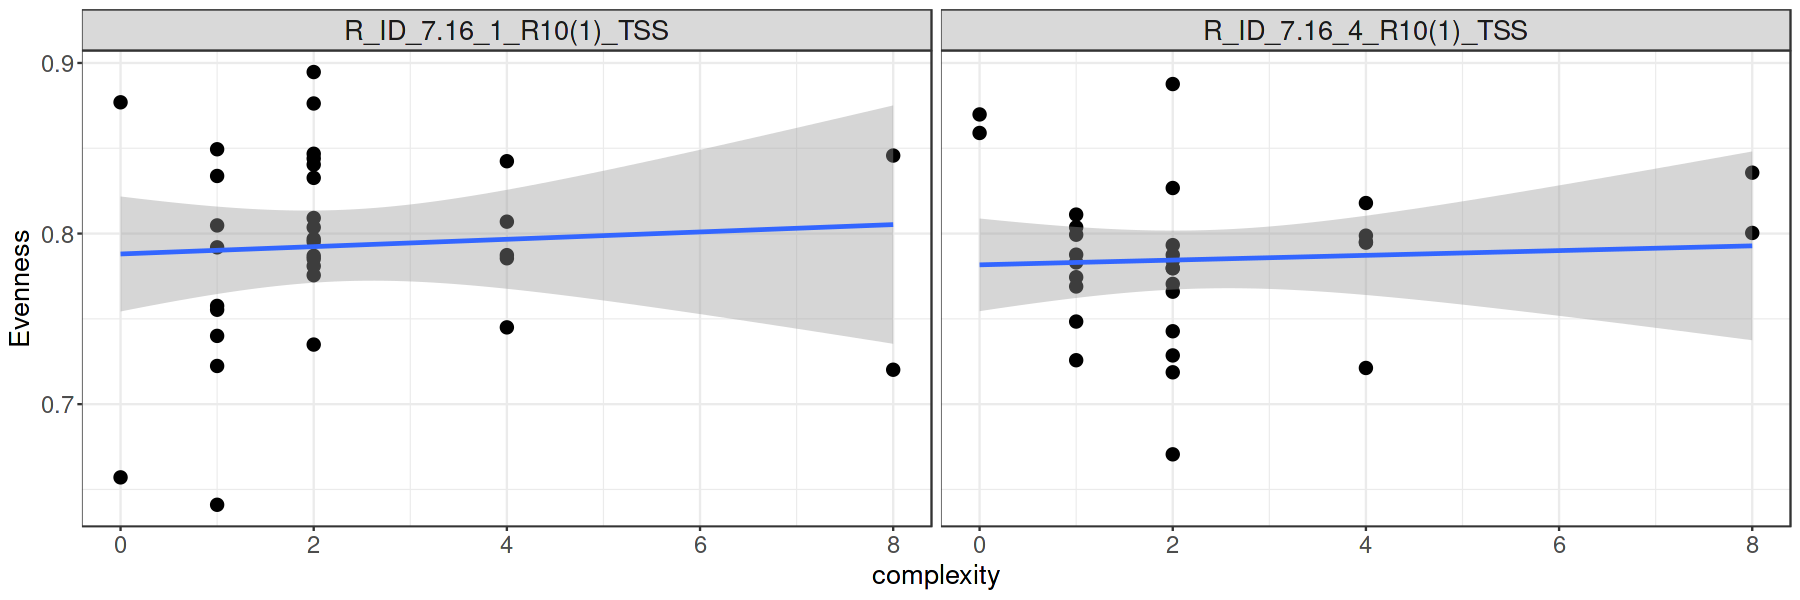

In [189]:
# can we calculate all the normal diveristy metrics with vegan?
library(vegan)

# transform the OTU table into the format vegan likes
rarefied_OTUs_t <- t(SVs)

diversity_shannon <- diversity(rarefied_OTUs_t)
diversity_simpson <- diversity(rarefied_OTUs_t, "simpson")
diversity_invsimp <- diversity(rarefied_OTUs_t, "inv")
diversity_alpha <- fisher.alpha(rarefied_OTUs_t)

species_richness <- specnumber(rarefied_OTUs_t)
evenness <- diversity_shannon/log(species_richness)

diversity_metrics <- data.frame(diversity_shannon, diversity_simpson, diversity_invsimp, diversity_alpha, species_richness,
                                evenness)
diversity_metrics$SampleID <- rownames(diversity_metrics)

# add the metadata back
diversity_metrics <- left_join(diversity_metrics, metadata)

# make a consistent plotting theme
new_theme <- theme_bw() +
  theme(axis.title = element_text(size = 16),
       axis.text = element_text(size = 14),
       strip.text = element_text(size = 16))

options(repr.plot.width = 15, repr.plot.height = 5)

ggplot(diversity_metrics, aes(x = complexity, y = species_richness)) + 
  geom_point(size = 3) + 
  geom_smooth(method = lm) +
  facet_wrap(~community.name) +
  labs(y = "Species Richness") +
  new_theme

ggplot(diversity_metrics, aes(x = complexity, y = diversity_shannon)) + 
  geom_point(size = 3) + 
  geom_smooth(method = lm) +
  facet_wrap(~community.name) +
  labs(y = "Shannon Diversity") +
  new_theme

ggplot(diversity_metrics, aes(x = complexity, y = evenness)) + 
  geom_point(size = 3) + 
  geom_smooth(method = lm) +
  facet_wrap(~community.name) +
  labs(y = "Evenness") +
  new_theme

No clear patterns of richness or diversity with more chemical stressors.

No clear pattern of evenness - *i.e.* communities aren't obviously getting more or less assymetrical with increased stress. 

## Phylogenetic comparative metrics

Rather than just diversity of the communities, we can also look at how phylogenetically diverse they are. Potentially this might be more meaningful - are we losing or gaining *phylogenetic* diversity? I also think community phylogenetic comparative metrics are underutilised for microbes, so I'll do it here.

Warning message in comparative.comm(tree, rarefied_OTUs_t):
“Mismatch between phylogeny and other data, dropping 3 tips”


,ntaxa.x,mntd.obs,mntd.rand.mean,mntd.rand.sd,mntd.obs.rank,mntd.obs.z,mntd.obs.p,runs.x,SampleID,ntaxa.y,⋯,Amoxicillin,Chlorothalonil,Diflufenican,Glyphosate,Imidacloprid,Metaldehyde,Oxytetracycline,Tebuconazole,complexity,TruePlateWell
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,22,0.023808322,0.02163254,0.008095904,632,0.2687515,0.631368631,1000,Sample1,22,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,NANA
2,27,0.012513811,0.01819976,0.006453077,202,-0.8811225,0.201798202,1000,Sample10,27,⋯,0,0,0,1,0,0,0,1,2,1G6
3,18,0.034978321,0.02641704,0.010294594,784,0.8316285,0.783216783,1000,Sample11,18,⋯,0,0,0,0,0,0,0,0,0,10F4
4,17,0.001921336,0.02800510,0.010996963,1,-2.3719063,0.000999001,1000,Sample12,17,⋯,1,0,0,0,0,1,0,0,2,11B4
5,28,0.009248759,0.01738352,0.006250271,100,-1.3015045,0.099900100,1000,Sample13,28,⋯,0,1,0,0,0,1,0,0,2,11B5
6,24,0.011792317,0.02038075,0.007273223,127,-1.1808290,0.126873127,1000,Sample14,24,⋯,0,1,0,0,0,0,0,0,1,11C2


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


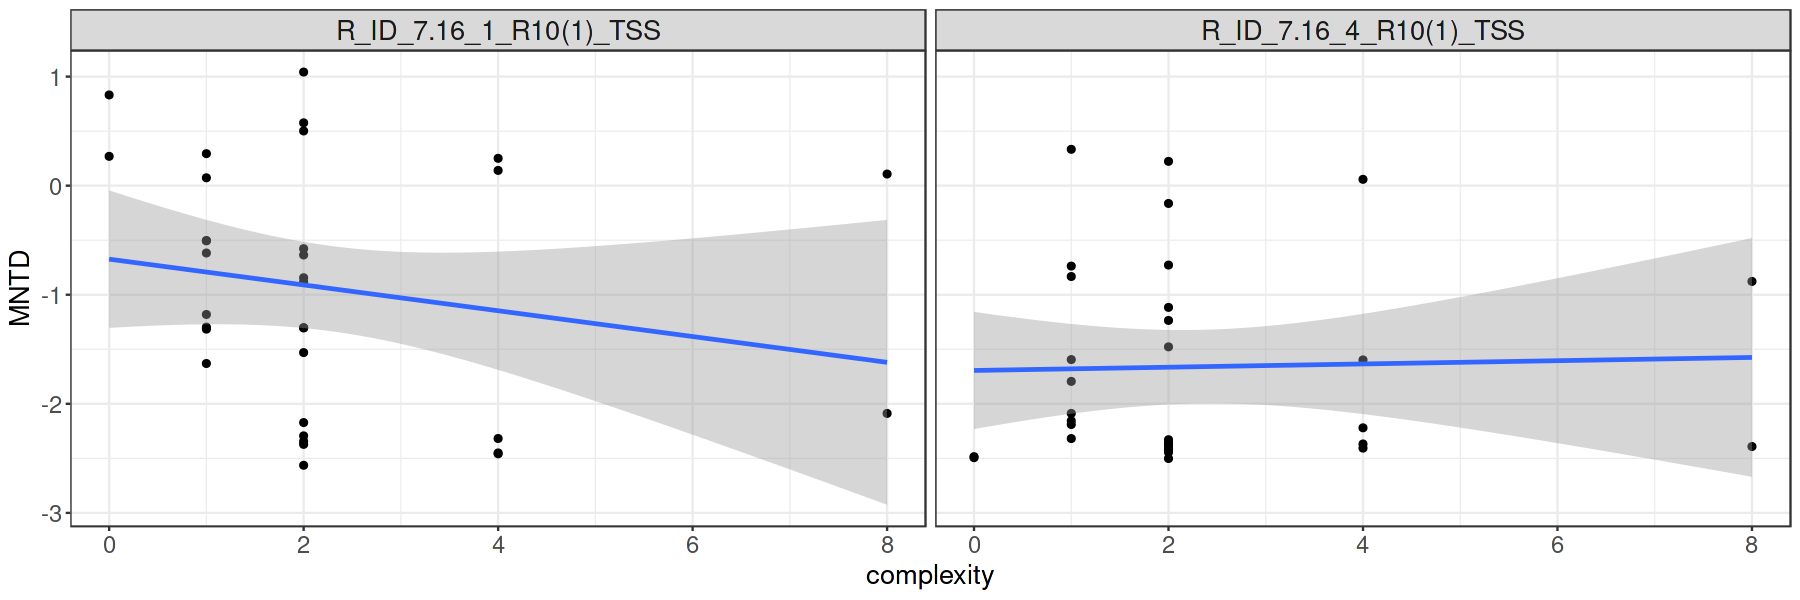

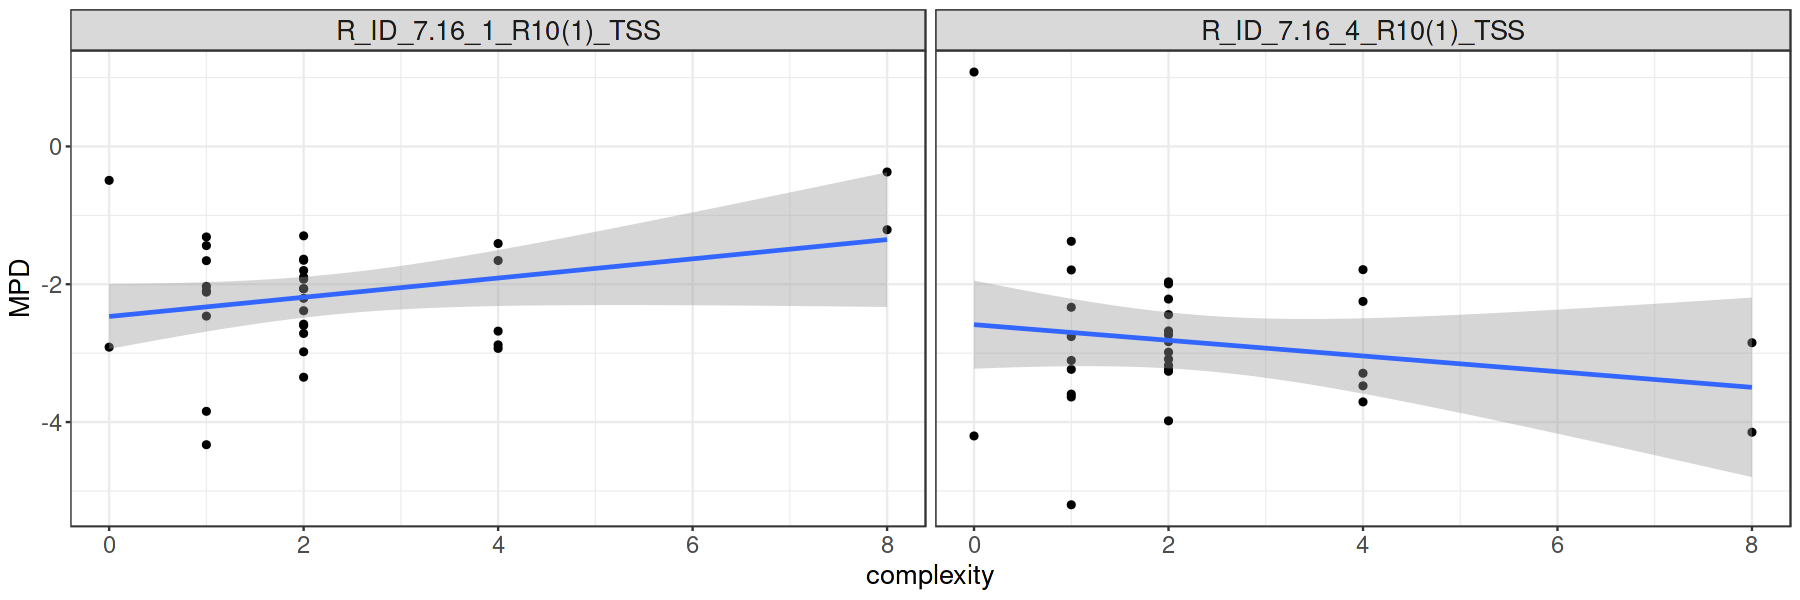

In [190]:
# use pez to calculate phyloegnetic metrics?
library(pez)

rarefied_OTUs <- SVs

# transform matrix for community phylogenetics metrics
rarefied_OTUs_t <- t(rarefied_OTUs)

OTU_compcomm <- comparative.comm(tree, rarefied_OTUs_t)

# calculate dispersion metrics
metrics_mntd <- .ses.mntd(OTU_compcomm) # mean nearest taxon distance
metrics_mpd <- .ses.mpd(OTU_compcomm) # mean phylogenetic distance

metrics_mntd$SampleID <- rownames(metrics_mntd)
metrics_mpd$SampleID <- rownames(metrics_mpd)

metrics <- left_join(metrics_mntd, metrics_mpd, by = "SampleID") %>%
  left_join(metadata, by = "SampleID")

head(metrics)

ggplot(metrics, aes(x = complexity, y = mntd.obs.z)) + 
  geom_point() + 
  facet_wrap(~community.name) +
  geom_smooth(method = lm) +
  labs(y = "MNTD") +
  new_theme

ggplot(metrics, aes(x = complexity, y = mpd.obs.z)) + 
  geom_point() + 
  facet_wrap(~community.name) +
  geom_smooth(method = lm) +
  labs(y = "MPD") +
  new_theme

Not much obviously useful going on there, only clear thing is that most of the communities across the board have negative standardized MNTD and MPD meaning that these are generally *phylogenetically clustered*, i.e. more similar than we might expect.

## Comparisons to functioning

We have data on the growth of these communities, can compare diversity to functioning.

,diversity_shannon,diversity_simpson,diversity_invsimp,diversity_alpha,species_richness,evenness,SampleID,sample.well,final.conc,community.name,⋯,Glyphosate,Imidacloprid,Metaldehyde,Oxytetracycline,Tebuconazole,complexity,TruePlateWell,AUC,mntd.obs.z,mpd.obs.z
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,2.812361,0.9260889,13.529765,7.554201,28,0.8439942,Sample41,D05,4,R_ID_7.16_1_R10(1)_TSS,⋯,1,0,0,0,1,2,6G6,9.345622,-1.304630,-2.064776
2,2.434140,0.8944889,9.477675,5.468861,22,0.7874818,Sample64,F04,4,R_ID_7.16_4_R10(1)_TSS,⋯,0,0,0,1,0,2,11C5,16.565083,-2.354632,-3.176498
3,2.699489,0.9200222,12.503473,6.139116,24,0.8494158,Sample14,B02,4,R_ID_7.16_1_R10(1)_TSS,⋯,0,0,0,0,0,1,11C2,8.732962,-1.180829,-1.439253
4,2.495483,0.8832222,8.563273,6.834269,26,0.7659328,Sample58,E10,4,R_ID_7.16_4_R10(1)_TSS,⋯,0,1,0,0,0,2,1F5,20.490570,-2.501575,-3.229542
5,2.677209,0.9174444,12.113055,6.139116,24,0.8424051,Sample43,D07,4,R_ID_7.16_1_R10(1)_TSS,⋯,1,0,0,1,0,4,8E3,6.252676,-2.450352,-2.880223
6,2.252016,0.8518000,6.747638,5.468861,22,0.7285620,Sample80,G08,4,R_ID_7.16_4_R10(1)_TSS,⋯,0,0,0,1,1,2,16G7,17.013581,-1.477774,-2.833417


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


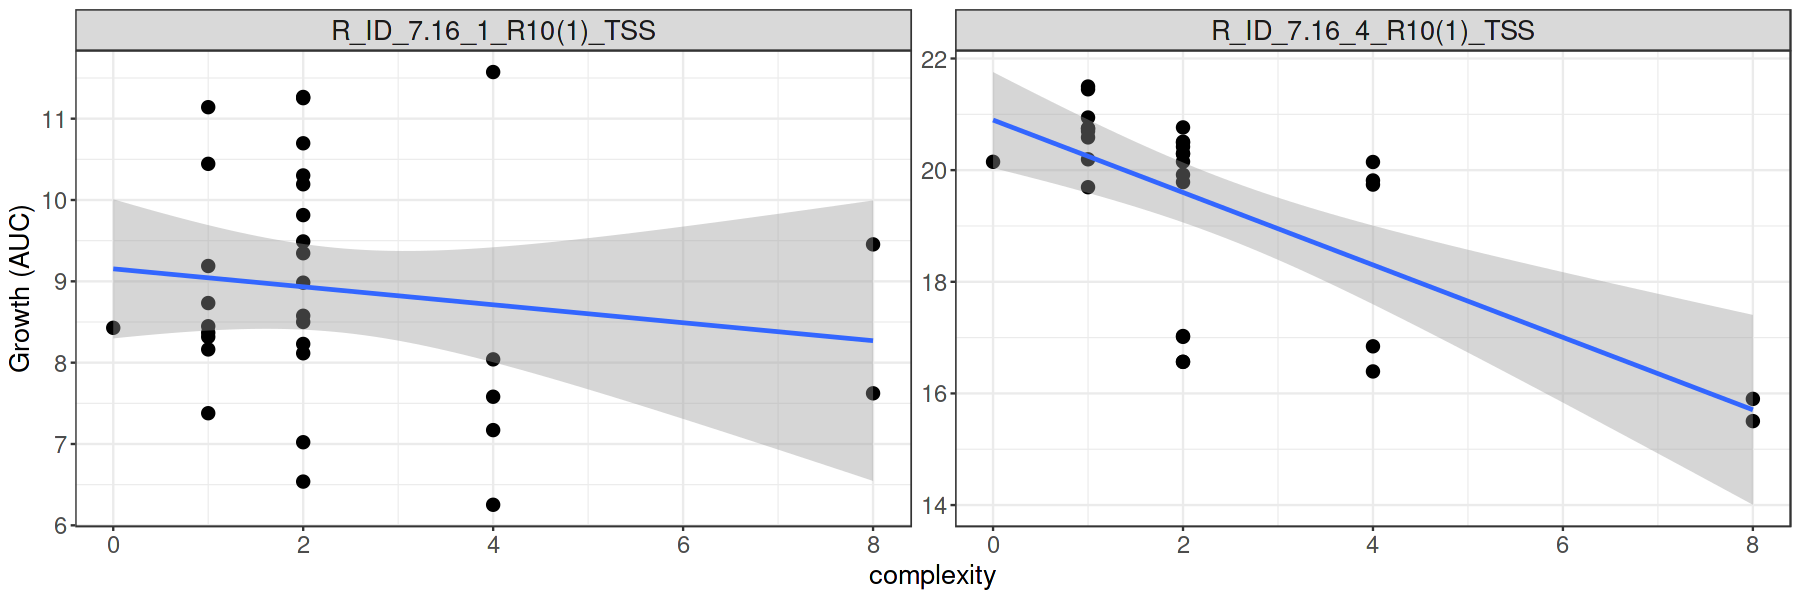

`geom_smooth()` using formula = 'y ~ x'


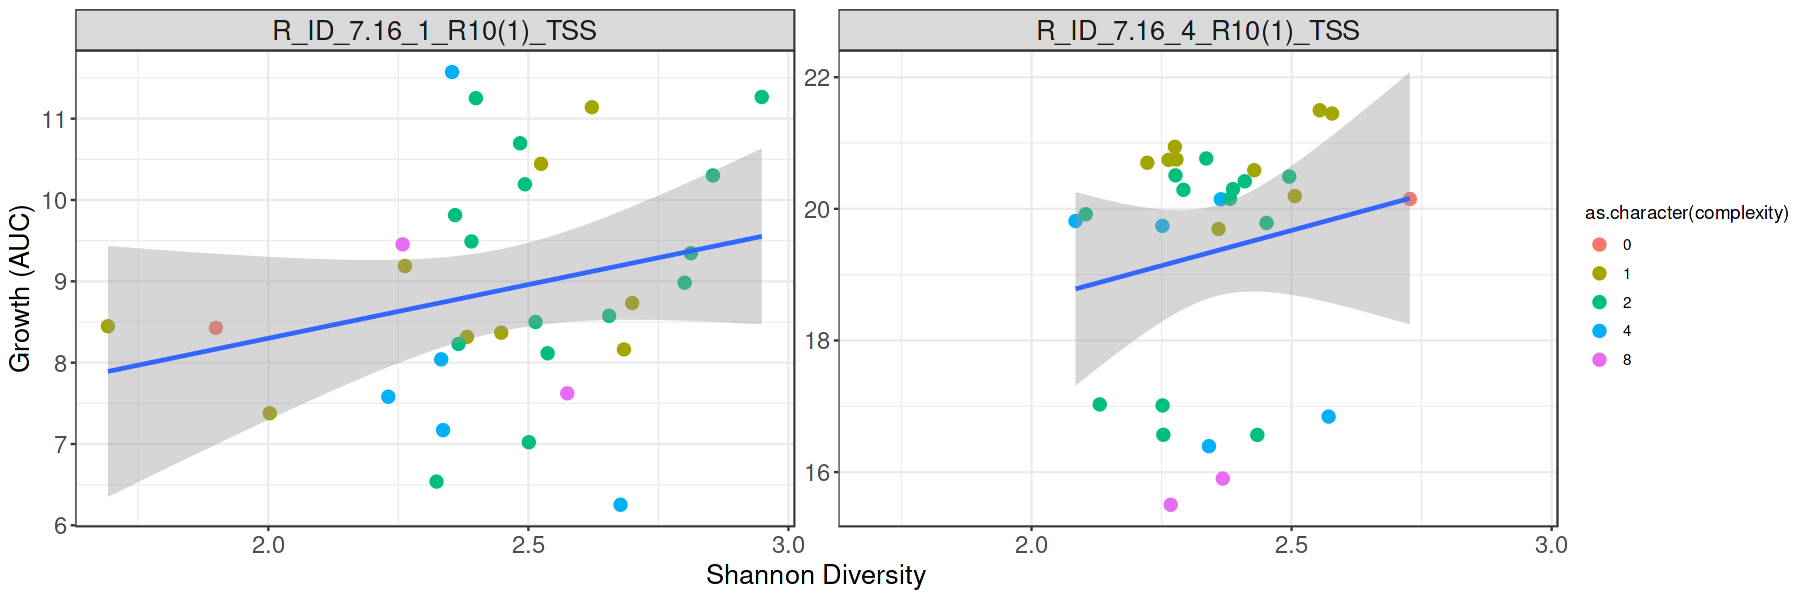

`geom_smooth()` using formula = 'y ~ x'


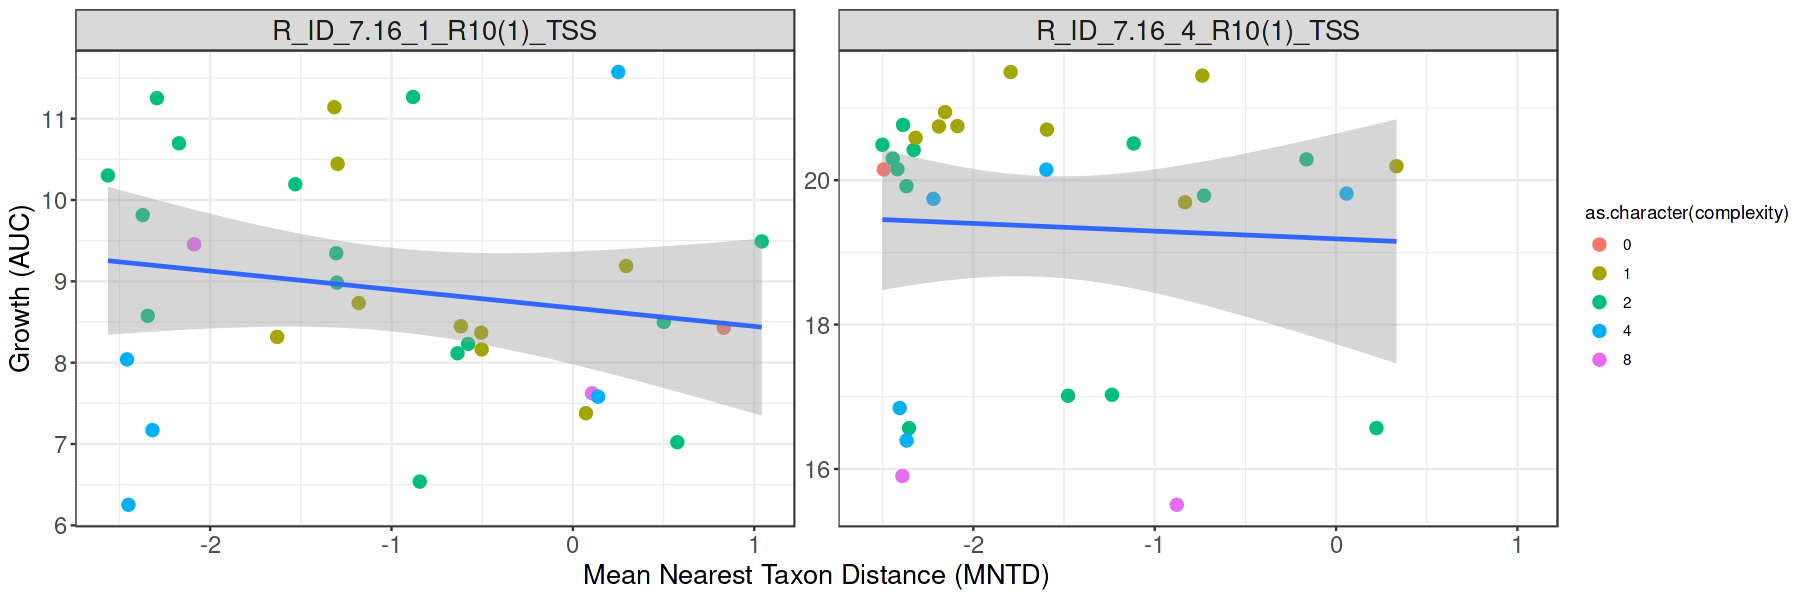

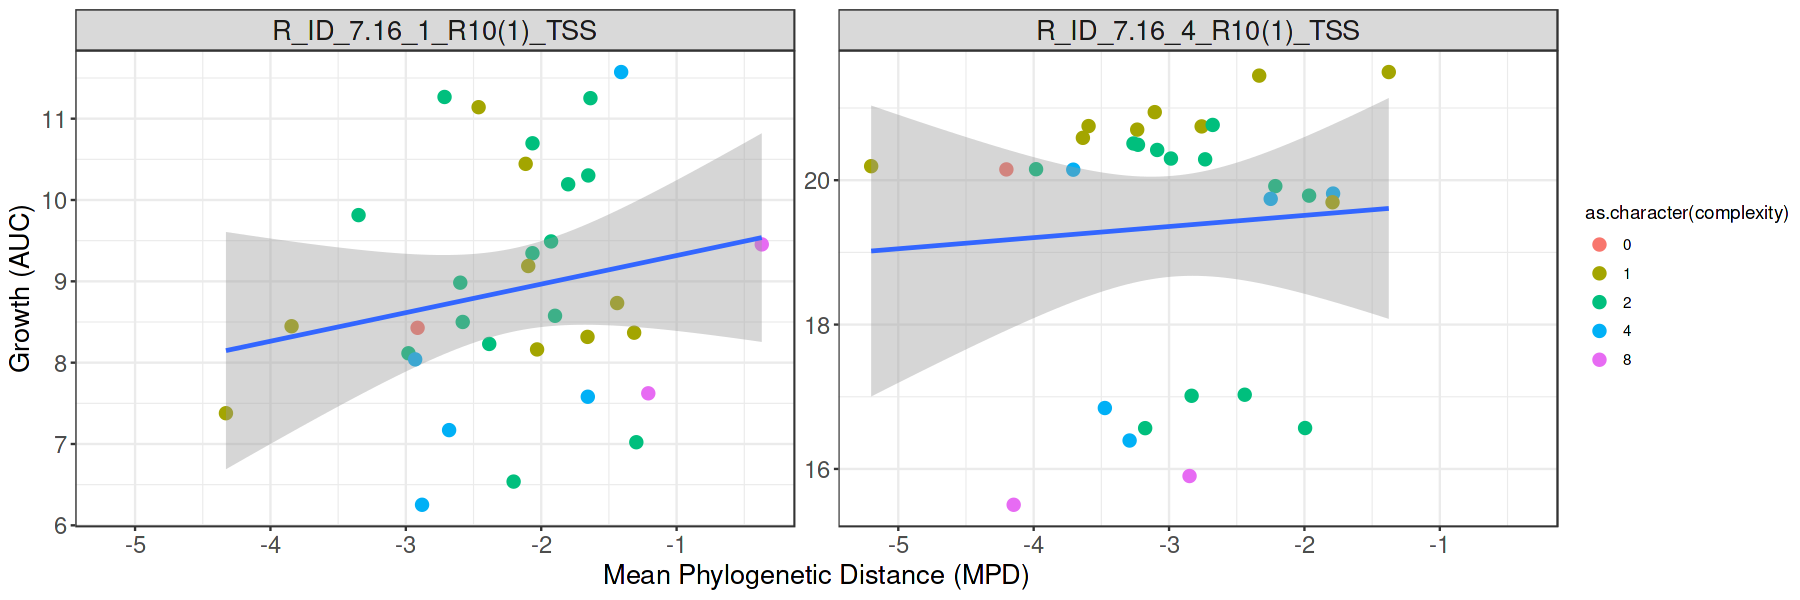

In [192]:
func_dat <- read.csv("../data/spline_fits.csv") %>%
  rename(community.name = Community) %>%
  select(community.name, TruePlateWell, AUC)

diversity_functioning <- diversity_metrics %>%
  filter(chem.code != "Frozen Starting Community") %>%
  left_join(func_dat, by = c("community.name", "TruePlateWell")) %>% # join the functional data
  left_join(metrics %>% 
              select(mntd.obs.z, mpd.obs.z, community.name, SampleID), 
            by = c("community.name", "SampleID")) # also join the phylogenetic diversity metrics


head(diversity_functioning)

ggplot(diversity_functioning, aes(x = complexity, y = AUC)) +
  geom_point(size = 3) +
  facet_wrap(~community.name, scales = "free_y") +
  geom_smooth(method = lm) +
  labs(y = "Growth (AUC)") +
  new_theme

ggplot(diversity_functioning, aes(x = diversity_shannon, y = AUC)) +
  geom_point(size = 3, aes(col = as.character(complexity))) +
  facet_wrap(~community.name, scales = "free_y") +
  geom_smooth(method = lm) +
  labs(y = "Growth (AUC)", x = "Shannon Diversity") +
  new_theme

ggplot(diversity_functioning, aes(x = mntd.obs.z, y = AUC)) +
  geom_point(size = 3, aes(col = as.character(complexity))) +
  facet_wrap(~community.name, scales = "free_y") +
  geom_smooth(method = lm) +
  labs(y = "Growth (AUC)", x = "Mean Nearest Taxon Distance (MNTD)") +
  new_theme

ggplot(diversity_functioning, aes(x = mpd.obs.z, y = AUC)) +
  geom_point(size = 3, aes(col = as.character(complexity))) +
  facet_wrap(~community.name, scales = "free_y") +
  geom_smooth(method = lm) +
  labs(y = "Growth (AUC)", x = "Mean Phylogenetic Distance (MPD)") +
  new_theme

OK... so while the functioning of the communities (overall growth) does tend to decrease with chemical additions, this functioning doesn't really seem to correlate with changes in our community (at least, not by the tests here).

Maybe we can use PiCRUST to get a better idea of functioning, which attempts to turn our 16S sequences into a metagenome of functional pathways.

Need to output the qiime artifacts into something that PiCRUST can read:

```
qiime tools export --input-path rarefied_table.qza --output-path rarefied_table
qiime tools export --input-path rarefied_sequences.qza --output-path rarefied_sequences
```

## PiCRUST workflow

First place the reads into a reference tree.
```
conda activate picrust2:

place_seqs.py -s ../run-1-rarefied/rarefied_sequences/sequences_rc.fa -o out.tre -p 4 --intermediate intermediate/place_seqs -t sepp
```
Then we do hidden-state prediction of gene families:
```
hsp.py -i 16S -t out.tre -o marker_predicted_and_nsti.tsv.gz -p 1 -n
hsp.py -i EC -t out.tre -o EC_predicted.tsv.gz -p 1
```
The output files of these commands are `marker_predicted_and_nsti.tsv.gz` and `EC_predicted.tsv.gz`.


`marker_predicted_and_nsti.tsv.gz`: The first column is the name of ASV (amplified sequence variant = OTU), followed by the predicted number of 16S copies per ASVs, followed finally by the NSTI (nearest-sequenced taxon index) value per ASV. ASVs with a NSTI score above 2 are usually noise. 

`EC_predicted.tsv.gz`: In this table the predicted copy number of all Enzyme Classification (EC) numbers is shown for each ASV. The NSTI values per ASV are not in this table since we did not specify the -n option. EC numbers are a type of gene family defined based on the chemical reactions they catalyze. For instance, EC:1.1.1.1 corresponds to alcohol dehydrogenase.

Now generate metagenome predictions. In the last step we predicted the copy numbers of gene families for each ASV. This output alone can be useful; however, often we are more interested in the predicted gene families weighted by the relative abundance of ASVs in their community. In other words, inferring the metagenomes of the communities. This output can be produced by plugging in the BIOM table of ASV abundances per samples.
```
metagenome_pipeline.py -i ../run-1-rarefied/rarefied_table/feature-table.biom -m marker_predicted_and_nsti.tsv.gz -f EC_predicted.tsv.gz -o EC_metagenome_out --strat_out
```
  - `EC_metagenome_out/pred_metagenome_unstrat.tsv.gz` - overall EC number abundances per sample.
  - `EC_metagenome_out/pred_metagenome_contrib.tsv.gz` - A stratified table in "contributional" format breaking down how the ASVs contribute to gene family abundances in each sample.
  - `EC_metagenome_out/seqtab_norm.tsv.gz` - the ASV abundance table normalized by predicted 16S copy number.
  - `EC_metagenome_out/weighted_nsti.tsv.gz` - the mean NSTI value per sample (when taking into account the relative abundance of the ASVs). This file can be useful for identifying outlier samples in your dataset. In PICRUSt1 weighted NSTI values < 0.06 and > 0.15 were suggested as good and high, respectively. The cut-offs can be useful for getting a ball-park of how your samples compare to other datasets, but a weighted NSTI score > 0.15 does not necessarily mean that the predictions are meaningless.

The last major step of the PICRUSt2 pipeline is to infer pathway-level abundances. By default this script infers MetaCyc pathway abundances based on EC number abundances, although different gene families and pathways can also be optionally specified. This script performs a number of steps by default, which are meant to be as similar as possible to the approach implemented in HUMAnN2
```
pathway_pipeline.py -i EC_metagenome_out/pred_metagenome_contrib.tsv.gz -o pathways_out -p 1
```
Finally, it can be useful to have a description of each functional id in the output abundance tables. The below commands will add these descriptions as new column in gene family and pathway abundance tables.

```
add_descriptions.py -i EC_metagenome_out/pred_metagenome_unstrat.tsv.gz -m EC -o EC_metagenome_out/pred_metagenome_unstrat_descrip.tsv.gz

add_descriptions.py -i pathways_out/path_abun_unstrat.tsv.gz -m METACYC -o pathways_out/path_abun_unstrat_descrip.tsv.gz
```

Cool, now try to analyze the output of these in R.

In [193]:
# Read in the PiCRUST outputs

# abundance of ECs in metagenome
EC_abundance <- as.data.frame(fread("../data/miseq-inhouse/pred_metagenome_unstrat_descrip.tsv.gz"))
# abundance of MetaCyc pathways in metagenome
MC_abundance <- as.data.frame(fread("../data/miseq-inhouse/path_abun_unstrat_descrip.tsv.gz"))


head(EC_abundance)
head(MC_abundance)

,function,description,Sample41,Sample64,Sample14,Sample58,Sample43,Sample80,Sample37,Sample59,⋯,Sample35,Sample2,Sample32,Sample55,Sample44,Sample73,Sample26,Sample70,Sample5,Sample54
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,EC:1.1.1.1,Alcohol dehydrogenase,436.6,494.20,323.88,241.8,407.6,258.20,375.0,537.00,⋯,380.2,389.40,347.4,569.50,335.68,242.2,384.68,408.90,440.28,503.30
2,EC:1.1.1.100,3-oxoacyl-[acyl-carrier-protein] reductase,698.2,446.95,270.27,351.3,858.6,593.95,333.0,445.75,⋯,324.0,740.90,818.4,550.49,286.56,485.7,329.31,378.15,357.16,414.54
3,EC:1.1.1.103,L-threonine 3-dehydrogenase,100.9,111.30,25.20,30.5,111.4,56.30,51.9,121.10,⋯,45.8,101.75,97.4,140.50,30.20,42.5,52.10,87.95,76.00,111.80
4,EC:1.1.1.108,Carnitine 3-dehydrogenase,0.2,0.00,0.00,0.0,0.0,0.00,0.0,0.00,⋯,0.6,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00
5,EC:1.1.1.11,D-arabinitol 4-dehydrogenase,28.2,20.00,19.00,52.6,32.0,48.00,39.8,19.20,⋯,39.6,31.80,37.6,12.20,41.80,49.4,36.60,21.20,24.60,19.40
6,EC:1.1.1.122,D-threo-aldose 1-dehydrogenase,0.0,2.50,64.74,1.0,0.0,0.50,0.0,0.50,⋯,0.0,2.00,0.0,1.26,0.00,3.0,0.50,3.50,0.00,0.76


,pathway,description,Sample41,Sample64,Sample14,Sample58,Sample43,Sample80,Sample37,Sample59,⋯,Sample35,Sample2,Sample32,Sample55,Sample44,Sample73,Sample26,Sample70,Sample5,Sample54
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1CMET2-PWY,N10-formyl-tetrahydrofolate biosynthesis,152.6639320,141.39340,89.36207,84.95333,160.93803,105.702554,110.02711,150.35750,⋯,109.11284,146.48181,144.06437,164.52704,95.99693,93.604461,110.37193,118.00466,122.88312,140.72443
2,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,4-hydroxyphenylacetate degradation,0.3991176,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,⋯,1.13917,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000
3,ALL-CHORISMATE-PWY,superpathway of chorismate metabolism,99.6702902,113.55995,54.14324,33.00508,78.88198,1.287447,89.00730,113.12701,⋯,85.24211,84.63889,52.01560,127.37546,67.57187,6.178911,89.00719,97.16371,102.93612,106.82215
4,ANAEROFRUCAT-PWY,homolactic fermentation,135.5057859,95.64099,91.50203,86.49453,134.62484,92.841484,99.92639,85.41490,⋯,95.79445,128.50210,117.00131,101.42062,89.25176,88.627021,95.64913,88.12853,84.30485,81.70757
5,ANAGLYCOLYSIS-PWY,glycolysis III (from glucose),134.0473365,147.30764,98.56105,86.17505,148.35664,108.414213,116.95506,157.89457,⋯,115.34148,134.31316,138.97193,167.91032,104.24306,97.352363,117.77704,123.58814,131.75519,148.29667
6,ARG+POLYAMINE-SYN,superpathway of arginine and polyamine biosynthesis,81.0000873,61.88112,55.87174,71.12370,85.29957,72.116085,74.86736,55.11042,⋯,72.87306,84.38948,83.81881,49.92457,69.84681,69.629232,73.42339,60.17863,67.42650,53.85456


In [194]:
# Also stratified tables in "contributional" format 
# breaking down how the ASVs contribute to gene family abundances in each sample.
EC_contrib <- as.data.frame(fread("../data/miseq-inhouse/pred_metagenome_contrib.tsv.gz"))
MC_contrib <- as.data.frame(fread("../data/miseq-inhouse/path_abun_contrib.tsv.gz"))

head(EC_contrib)
head(MC_contrib)

,sample,function,taxon,taxon_abun,taxon_rel_abun,genome_function_count,taxon_function_abun,taxon_rel_function_abun,norm_taxon_function_contrib
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,Sample41,EC:1.1.1.1,03d62691f2499275393bd38435436557,5.0,3.5137034,3,15.0,10.541110,0.034356390
2,Sample41,EC:1.1.1.1,0a899e4983e000a4c2b115dc0a8d1d70,11.0,7.7301476,2,22.0,15.460295,0.050389372
3,Sample41,EC:1.1.1.1,1865bb85bc7261ea82c2c6d95a09360a,1.0,0.7027407,4,4.0,2.810963,0.009161704
4,Sample41,EC:1.1.1.1,1aac58cbd99933ef97e13f5e72c3f92f,3.4,2.3893183,4,13.6,9.557273,0.031149794
5,Sample41,EC:1.1.1.1,31580519cd934b43ab776fd4a9073204,1.0,0.7027407,5,5.0,3.513703,0.011452130
6,Sample41,EC:1.1.1.1,3b72c114171becb2a5868e8b59e249f8,9.0,6.3246662,2,18.0,12.649332,0.041227668


,sample,function,taxon,taxon_abun,taxon_rel_abun,genome_function_count,taxon_function_abun,taxon_rel_function_abun
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Sample1,1CMET2-PWY,1aac58cbd99933ef97e13f5e72c3f92f,3.0,1.3551360,1.1243239,3.3729716,1.5236117
2,Sample1,1CMET2-PWY,30a9ca8d876f7a37ab124470b47c9471,0.8,0.3613696,0.8744741,0.6995793,0.3160084
3,Sample1,1CMET2-PWY,31580519cd934b43ab776fd4a9073204,27.0,12.1962237,0.9993990,26.9837730,12.1888938
4,Sample1,1CMET2-PWY,4ae50a40814d6171f3a7c1c128750999,1.2,0.5420544,0.8744741,1.0493690,0.4740125
5,Sample1,1CMET2-PWY,50211b248e925cdd198cef4412664d51,5.0,2.2585599,0.9993990,4.9969950,2.2572025
6,Sample1,1CMET2-PWY,692fc60710b744c4d9b68f247ed47cf2,1.6,0.7227392,0.8744741,1.3991586,0.6320167


As a first step we can treat these enzymes and pathways as if they were OTUs, only instead of describing taxa, they're describing function. We can look at some of the same metrics as previously (alpha diversity, richness, evenness) and see if they change with chemical additions, but in terms of function rather than taxa.

Can't do the phylogenetic metrics here, because we have no phylogeny of enzyme pathways...

### Enzymes first

Joining, by = "SampleID"


,EC_richness,EC_shannon,EC_simpson,EC_evenness,SampleID,sample.well,final.conc,community.name,chem.code,Amoxicillin,Chlorothalonil,Diflufenican,Glyphosate,Imidacloprid,Metaldehyde,Oxytetracycline,Tebuconazole,complexity,TruePlateWell
,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,1245,6.744058,0.9983177,0.9462834,Sample41,D05,4,R_ID_7.16_1_R10(1)_TSS,GT,0,0,0,1,0,0,0,1,2,6G6
2,1158,6.632332,0.9981562,0.9401629,Sample64,F04,4,R_ID_7.16_4_R10(1)_TSS,CO,0,1,0,0,0,0,1,0,2,11C5
3,1291,6.733095,0.9983009,0.9399600,Sample14,B02,4,R_ID_7.16_1_R10(1)_TSS,C,0,1,0,0,0,0,0,0,1,11C2
4,1158,6.707872,0.9982414,0.9508711,Sample58,E10,4,R_ID_7.16_4_R10(1)_TSS,DI,0,0,1,0,1,0,0,0,2,1F5
5,1135,6.720751,0.9982844,0.9554138,Sample43,D07,4,R_ID_7.16_1_R10(1)_TSS,CDGO,0,1,1,1,0,0,1,0,4,8E3
6,1149,6.687154,0.9982497,0.9489838,Sample80,G08,4,R_ID_7.16_4_R10(1)_TSS,OT,0,0,0,0,0,0,1,1,2,16G7


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


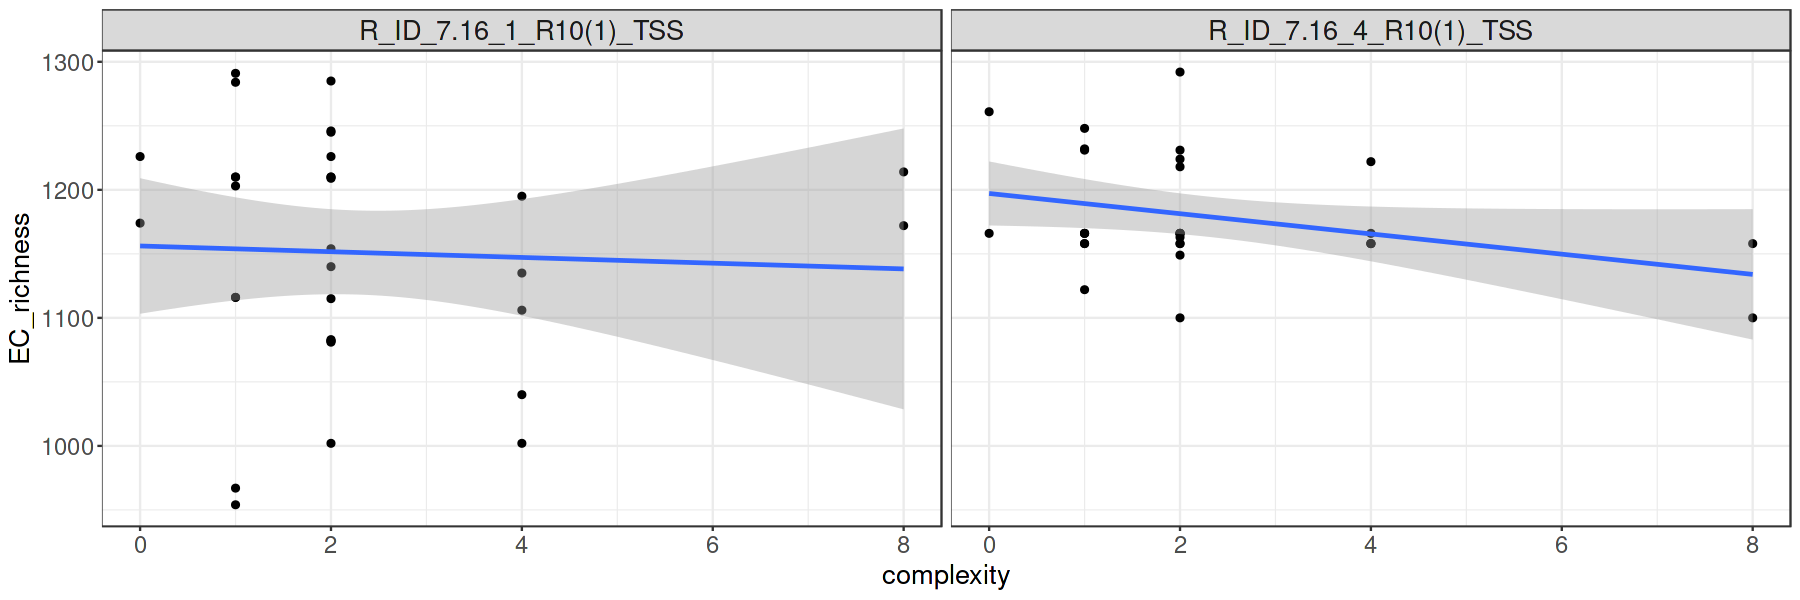

`geom_smooth()` using formula = 'y ~ x'


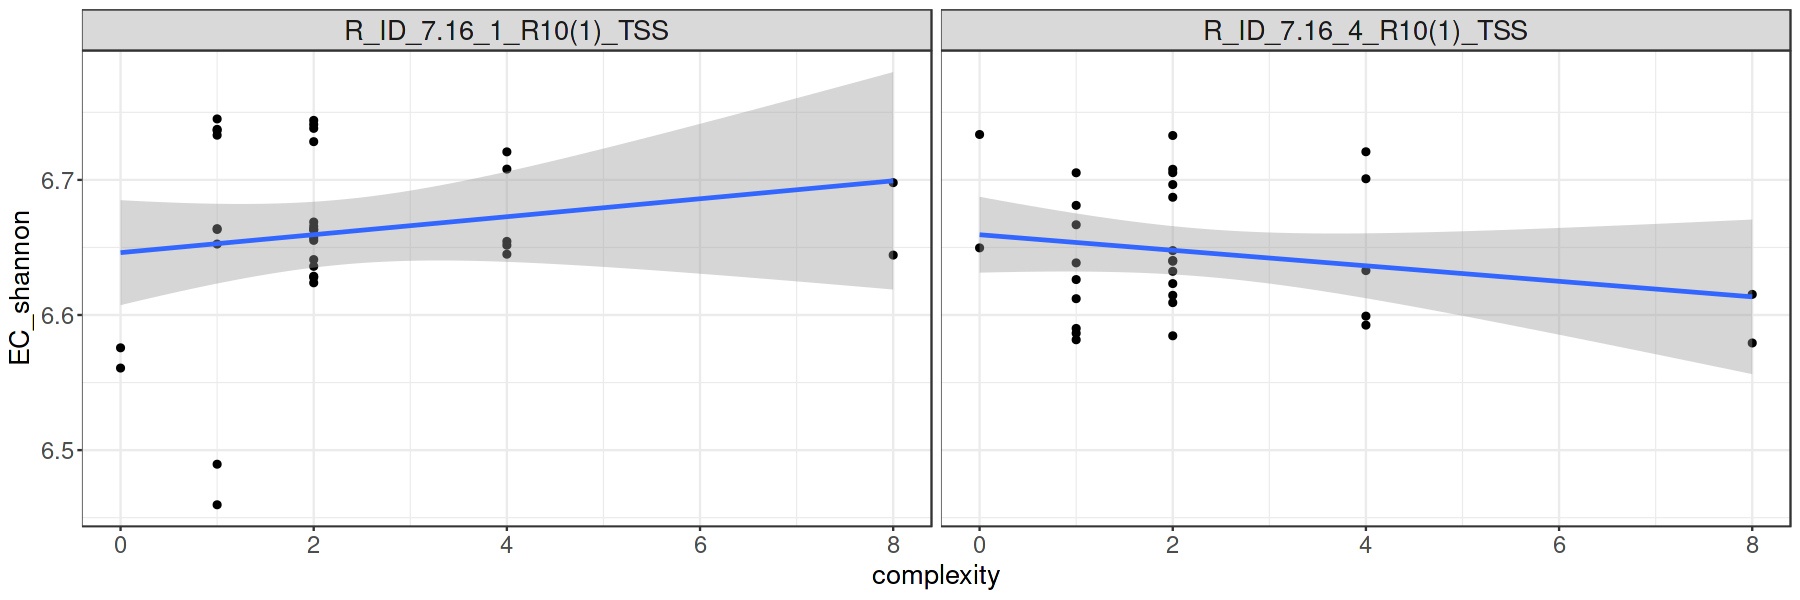

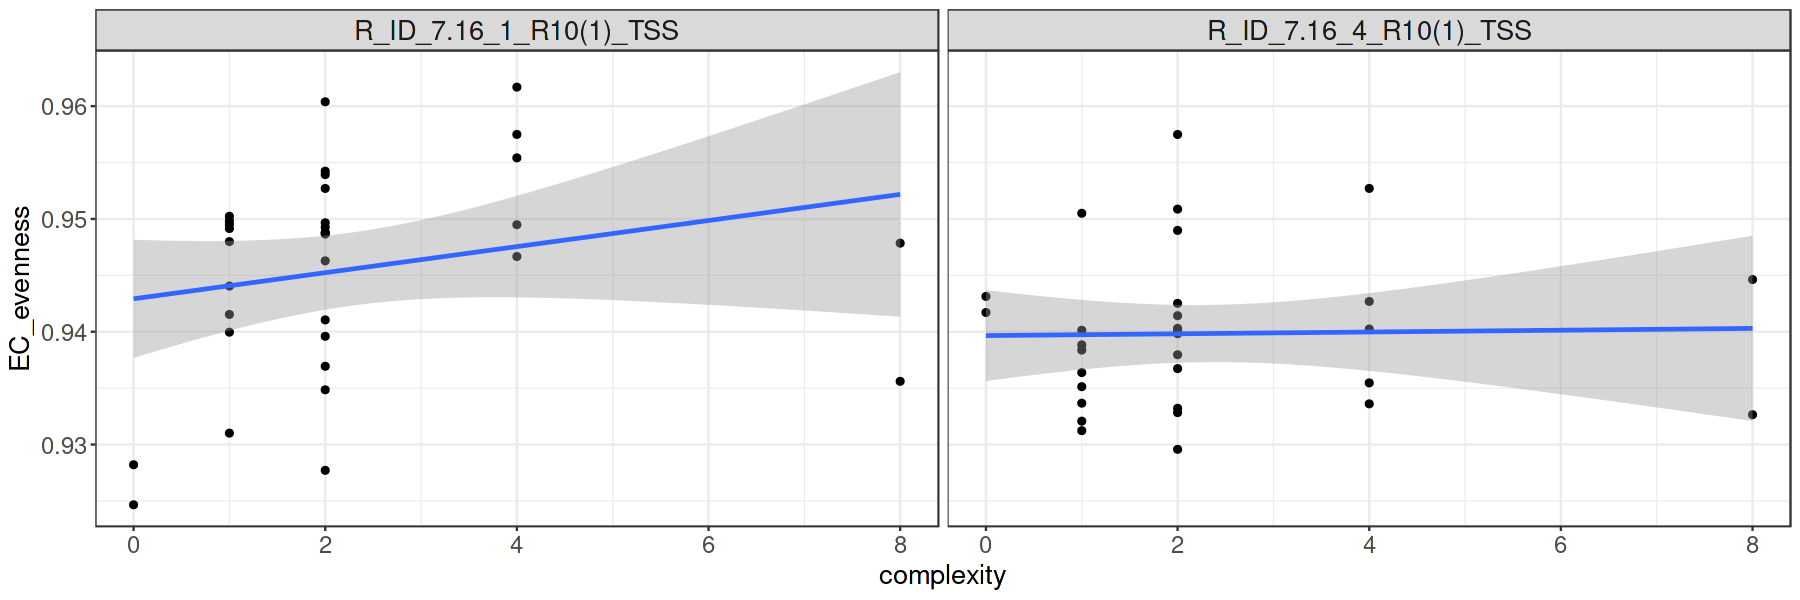

In [195]:
# transform these data into the sort of matrix that vegan likes
EC_matrix <- data.matrix(EC_abundance[,3:66])
dimnames(EC_matrix)[[1]] <- EC_abundance$description
EC_matrix_t <- t(EC_matrix)

# diversity metrics
EC_richness <- specnumber(EC_matrix_t)
EC_shannon <- diversity(EC_matrix_t)
EC_simpson <- diversity(EC_matrix_t, "simpson")
EC_evenness <- EC_shannon/log(EC_richness)

EC_diversity_metrics <- data.frame(EC_richness, EC_shannon, EC_simpson, EC_evenness)
EC_diversity_metrics$SampleID <- rownames(EC_diversity_metrics)

# add the metadata back
EC_diversity_metrics <- left_join(EC_diversity_metrics, metadata)

head(EC_diversity_metrics)

# plot it
ggplot(EC_diversity_metrics, aes(x = complexity, y = EC_richness)) + 
  geom_point() +
  geom_smooth(method = lm) +
  facet_wrap(~community.name) +
  new_theme

ggplot(EC_diversity_metrics, aes(x = complexity, y = EC_shannon)) + 
  geom_point() + 
  geom_smooth(method = lm) +
  facet_wrap(~community.name) +
  new_theme

ggplot(EC_diversity_metrics, aes(x = complexity, y = EC_evenness)) + 
  geom_point() +
  geom_smooth(method = lm) +
  facet_wrap(~community.name) +
  new_theme

### Pathways next

Joining, by = "SampleID"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


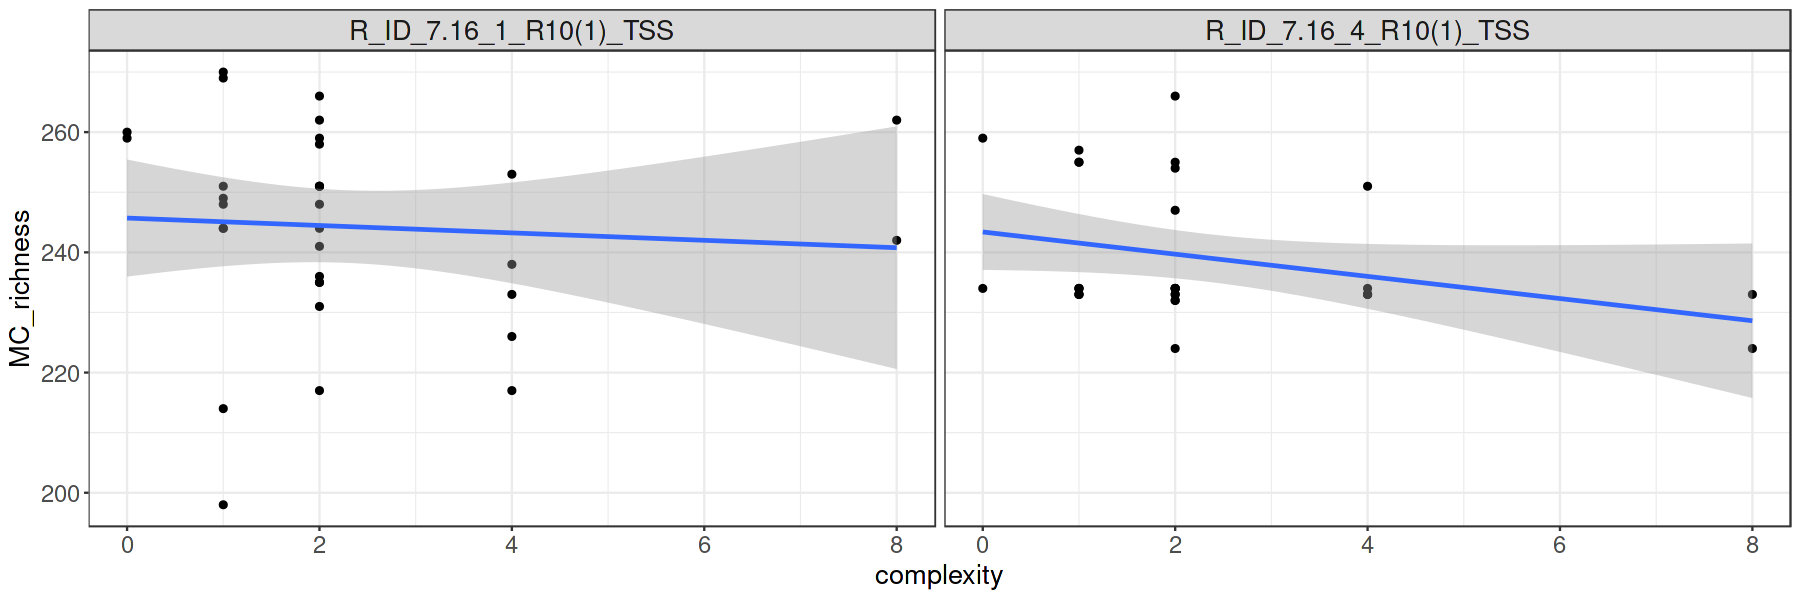

`geom_smooth()` using formula = 'y ~ x'


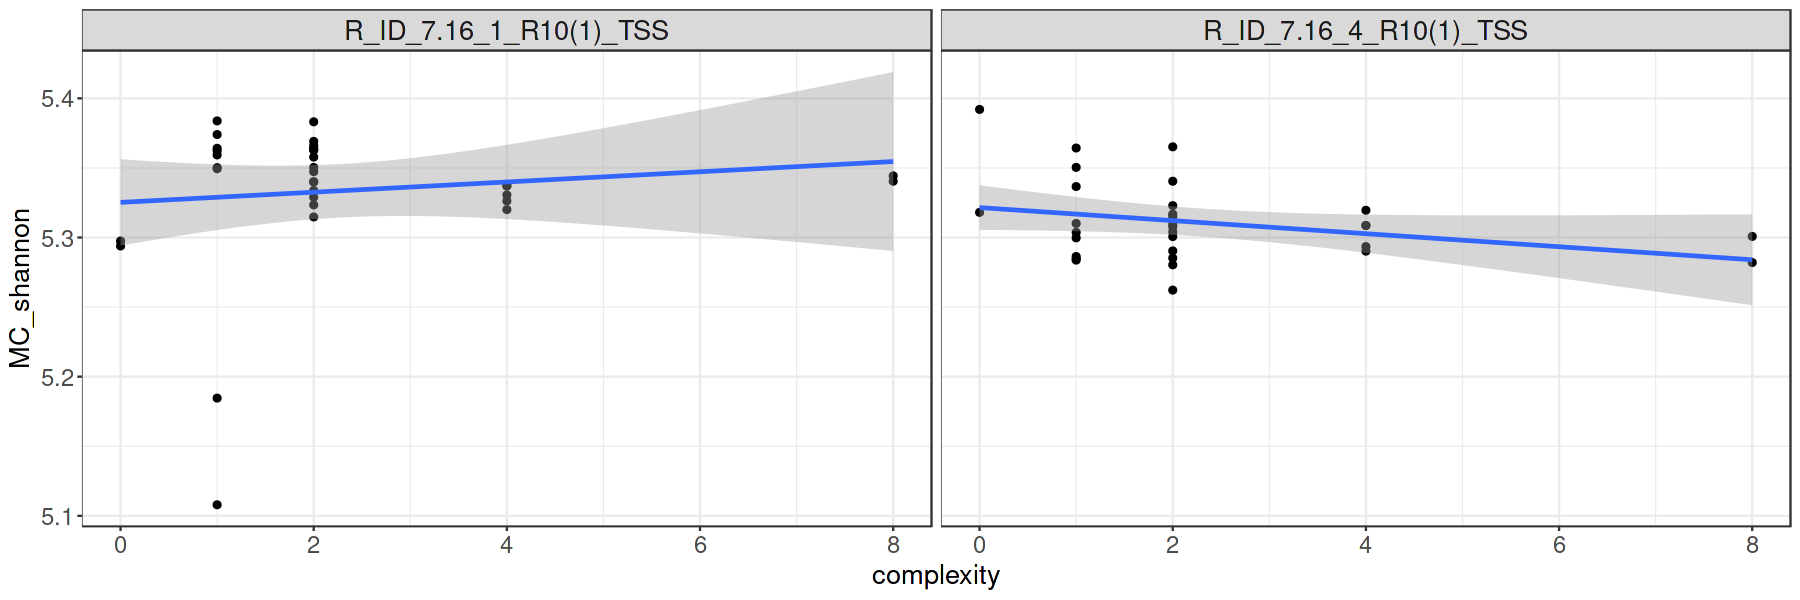

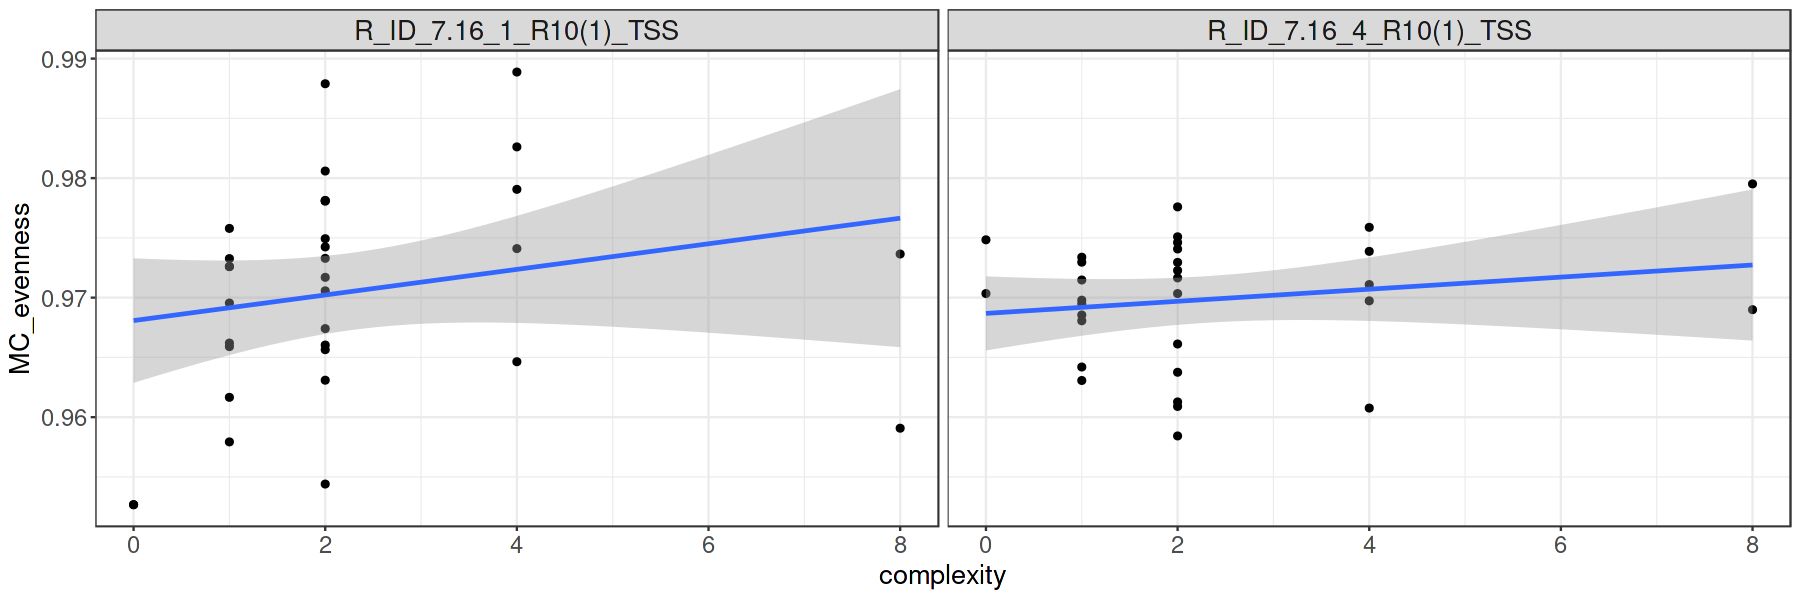

In [196]:
MC_matrix <- data.matrix(MC_abundance[,3:66])
dimnames(MC_matrix)[[1]] <- MC_abundance$description
MC_matrix_t <- t(MC_matrix)

MC_richness <- specnumber(MC_matrix_t)
MC_shannon <- diversity(MC_matrix_t)
MC_simpson <- diversity(MC_matrix_t, "simpson")

MC_evenness <- MC_shannon/log(MC_richness)

MC_diversity_metrics <- data.frame(MC_richness, MC_shannon, MC_simpson, MC_evenness)
MC_diversity_metrics$SampleID <- rownames(MC_diversity_metrics)
MC_diversity_metrics <- left_join(MC_diversity_metrics, metadata)

ggplot(MC_diversity_metrics, aes(x = complexity, y = MC_richness)) + 
  geom_point() + 
  geom_smooth(method = lm) +
  facet_wrap(~community.name) +
  new_theme

ggplot(MC_diversity_metrics, aes(x = complexity, y = MC_shannon)) + 
  geom_point() + 
  geom_smooth(method = lm) +
  facet_wrap(~community.name) +
  new_theme

ggplot(MC_diversity_metrics, aes(x = complexity, y = MC_evenness)) + 
  geom_point() + 
  geom_smooth(method = lm) + 
  facet_wrap(~community.name) +
  new_theme

Nothing jumps out as a consistent pattern really.

Try to look at generalism vs specialism of the communities, potential metric to look at that:

$$
\frac{\text{number of pathways}}{ \text{species richness}}
$$

i.e. the number of pathways per species in each community. We would expect more generalist communities to have generally more pathways per species?

Joining, by = "SampleID"
Joining, by = "SampleID"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


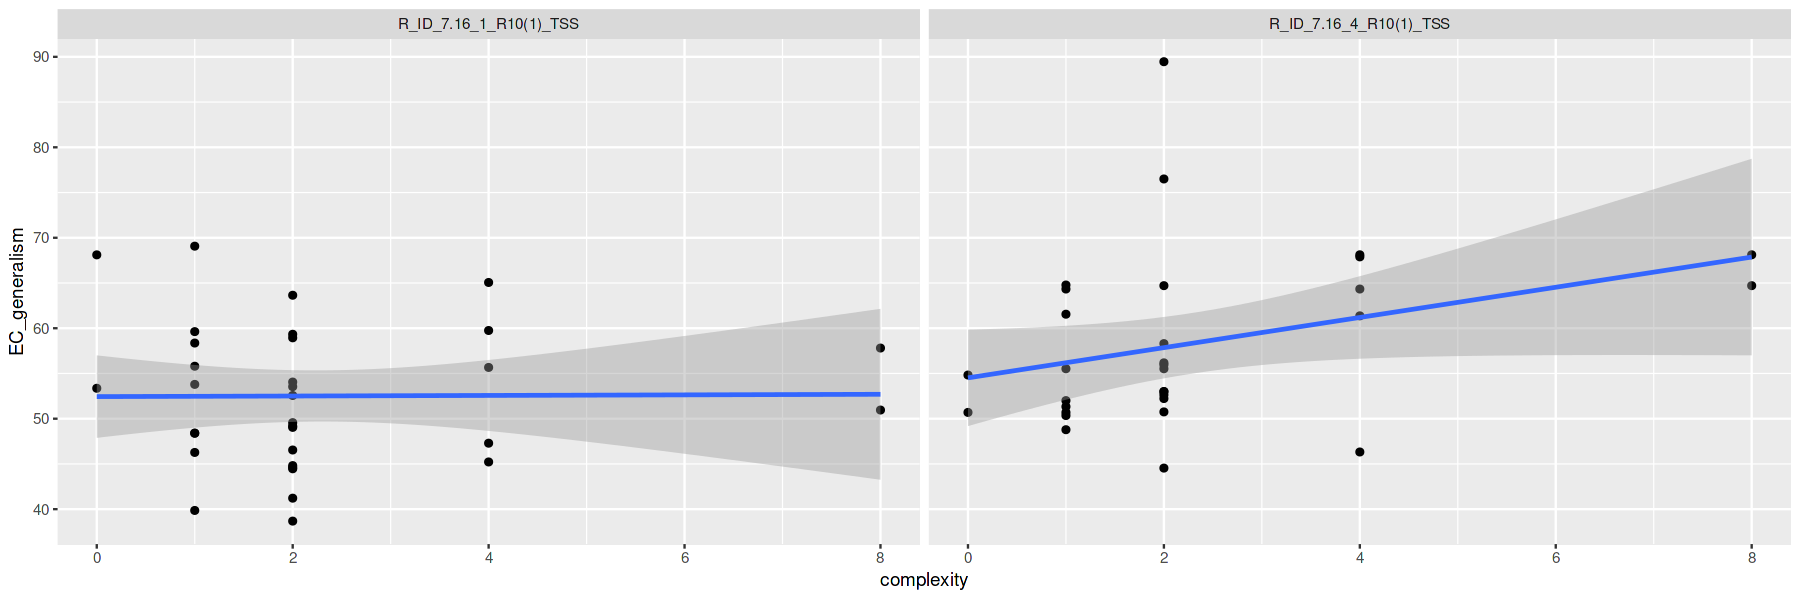

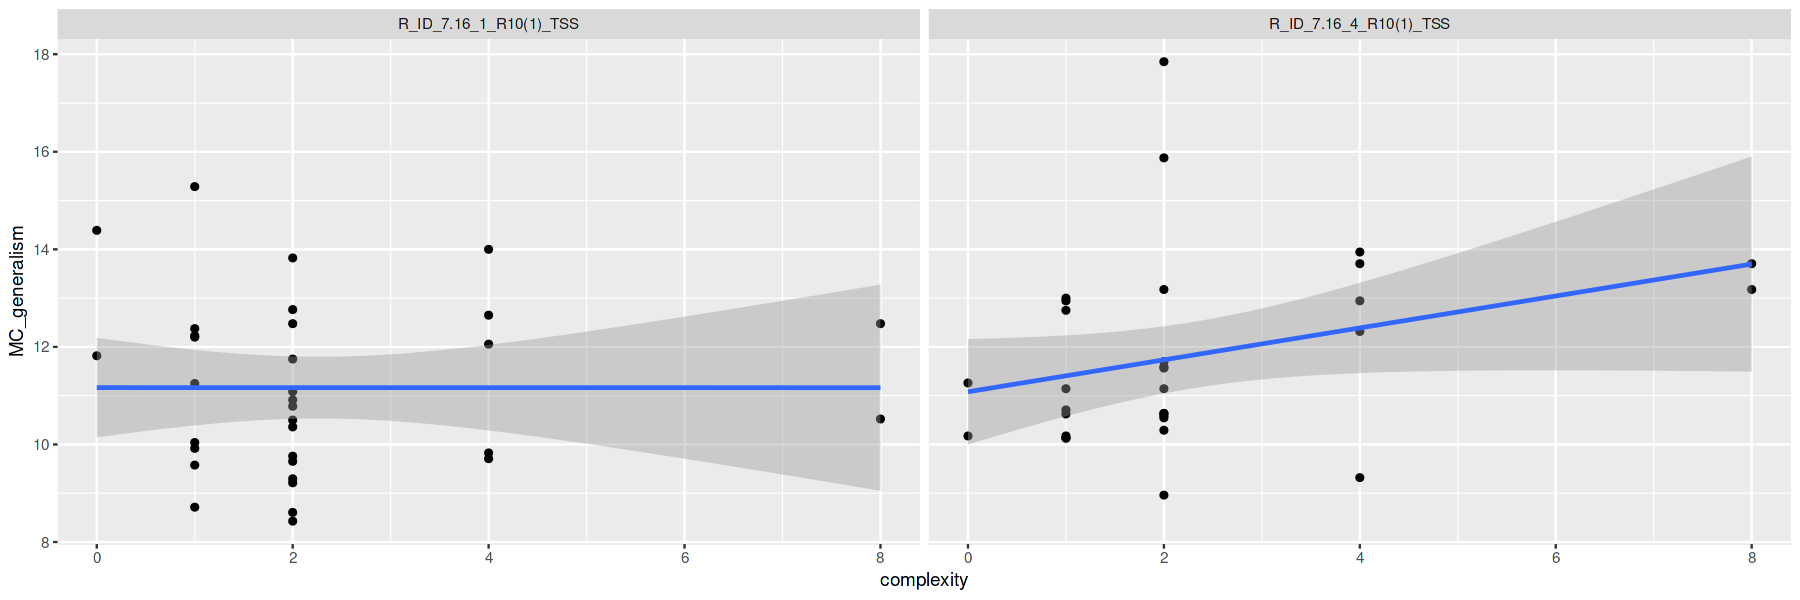

In [197]:
# maybe need to merge everything together in order to do that
diversity_metrics <- diversity_metrics %>%
  left_join(EC_diversity_metrics[,1:5]) %>%
  left_join(MC_diversity_metrics[,1:5])

diversity_metrics <- diversity_metrics %>%
  mutate(EC_generalism = EC_richness/species_richness,
         MC_generalism = MC_richness/species_richness)

# now look at whether that generalism/specialism changed with complexity of chemical mixture
ggplot(diversity_metrics, aes(x = complexity, y = EC_generalism)) + 
  geom_point() + 
  geom_smooth(method = lm) +
  facet_wrap(~community.name)

ggplot(diversity_metrics, aes(x = complexity, y = MC_generalism)) + 
  geom_point() + 
  geom_smooth(method = lm) +
  facet_wrap(~community.name)

In [198]:
# Does community 2 seem to be getting more generalist with the addition of more chemicals?

summary(lm(EC_generalism ~ complexity, data = diversity_metrics %>% filter(community.name == "R_ID_7.16_4_R10(1)_TSS")))

summary(lm(MC_generalism ~ complexity, data = diversity_metrics %>% filter(community.name == "R_ID_7.16_4_R10(1)_TSS")))


Call:
lm(formula = EC_generalism ~ complexity, data = diversity_metrics %>% 
    filter(community.name == "R_ID_7.16_4_R10(1)_TSS"))

Residuals:
    Min      1Q  Median      3Q     Max 
-14.872  -5.036  -1.899   4.253  31.608 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  54.5157     2.6076  20.906   <2e-16 ***
complexity    1.6690     0.8852   1.885   0.0694 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.131 on 29 degrees of freedom
Multiple R-squared:  0.1092,	Adjusted R-squared:  0.07848 
F-statistic: 3.555 on 1 and 29 DF,  p-value: 0.06942



Call:
lm(formula = MC_generalism ~ complexity, data = diversity_metrics %>% 
    filter(community.name == "R_ID_7.16_4_R10(1)_TSS"))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0689 -1.1208 -0.2643  0.9362  6.1117 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  11.0799     0.5291  20.940   <2e-16 ***
complexity    0.3273     0.1796   1.822   0.0788 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.853 on 29 degrees of freedom
Multiple R-squared:  0.1027,	Adjusted R-squared:  0.07176 
F-statistic: 3.319 on 1 and 29 DF,  p-value: 0.07881


Statistically... no.

Maybe the answer here will be not to be too concerned about changes with increasing numbers of chemicals, but with changes due to the specific chemicals themselves. TBD....